In [1]:
#deep learning packages
import keras
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping #saves model from overfitting
from keras.preprocessing.text import one_hot #converts words to number
from keras.preprocessing.sequence import pad_sequences 
from keras.utils import to_categorical #converts label to binary
from keras.callbacks import EarlyStopping

#machine learning packages
from sklearn.preprocessing import LabelEncoder #converts word/category to nuber
import numpy as np
import pandas as pd
import pickle
import nltk
import re
from nltk.stem import PorterStemmer  

import seaborn as sns #for visualization 
import matplotlib.pyplot as plt 
from wordcloud import WordCloud 

2024-02-03 06:56:20.121562: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-03 06:56:20.121713: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-03 06:56:20.268420: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
train_data = pd.read_csv("/kaggle/input/testtxt/train.txt",header=None , sep=';',names=['Sentences','Emotion'],encoding='utf-8')

In [3]:
train_data = train_data[train_data['Emotion'] != 'surprise']


In [4]:
train_data.shape

(15428, 2)

In [5]:
#get all words length in comment
train_data['length'] = [len(x) for x in train_data['Sentences']]

In [6]:
train_data

,Sentences,Emotion,length
0,i didnt feel humiliated,sadness,23
1,i can go from feeling so hopeless to so damned...,sadness,108
2,im grabbing a minute to post i feel greedy wrong,anger,48
3,i am ever feeling nostalgic about the fireplac...,love,92
4,i am feeling grouchy,anger,20
...,...,...,...
15995,i just had a very brief time in the beanbag an...,sadness,101
15996,i am now turning and i feel pathetic that i am...,sadness,102
15997,i feel strong and good overall,joy,30
15998,i feel like this was such a rude comment and i...,anger,59


In [7]:
train_data.isnull().sum()

Sentences    0
Emotion      0
length       0
dtype: int64

In [8]:
train_data.drop_duplicates(inplace=True)

In [9]:
train_data.shape

(15427, 3)

In [10]:
train_data['Emotion'].value_counts()

Emotion
joy        5361
sadness    4666
anger      2159
fear       1937
love       1304
Name: count, dtype: int64

<function matplotlib.pyplot.show(close=None, block=None)>

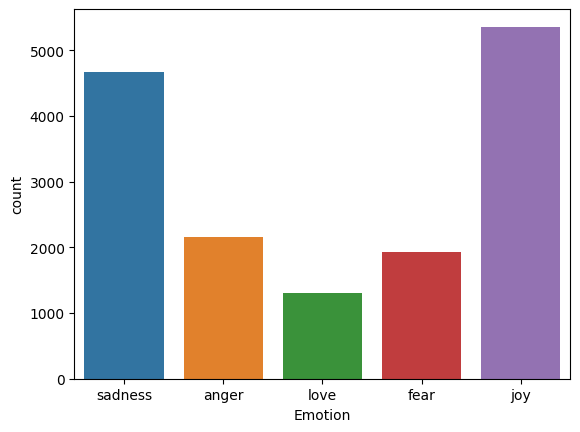

In [11]:
sns.countplot(x=train_data['Emotion'])
plt.show

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

<function matplotlib.pyplot.show(close=None, block=None)>

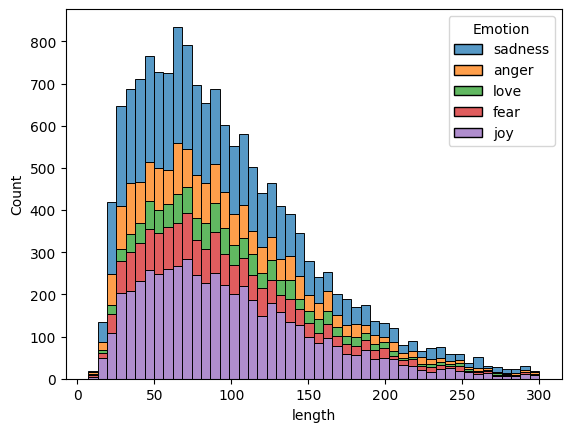

In [12]:
#data distribution
df = train_data.copy()
#conver thte 'length' column to a numpy array
length_values = df['length'].values
#use sns.histplot of sns.kdeplot 
sns.histplot(data=df, x='length' , hue='Emotion',multiple='stack')
plt.show


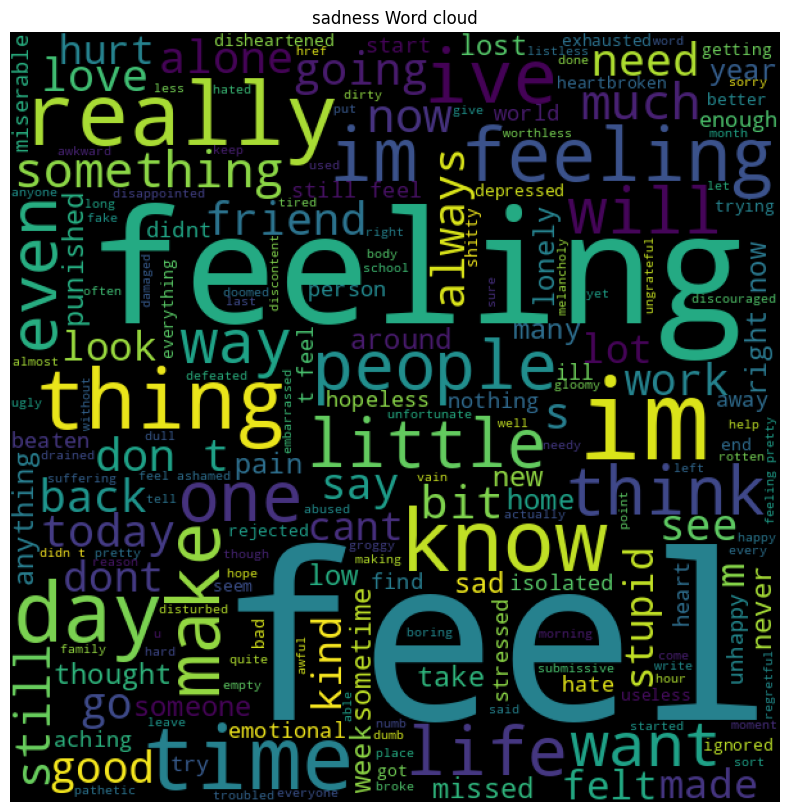

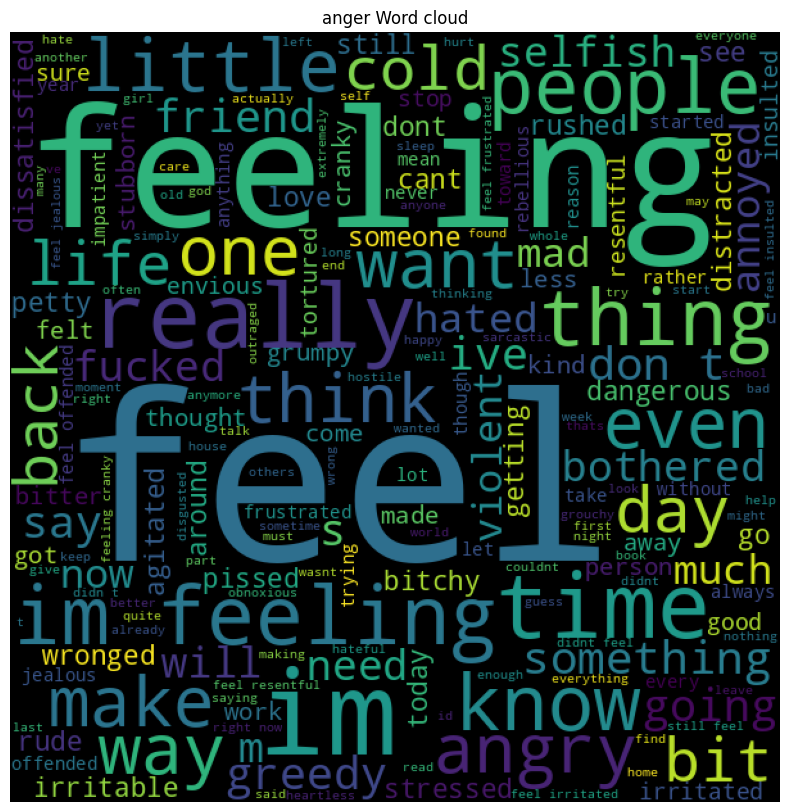

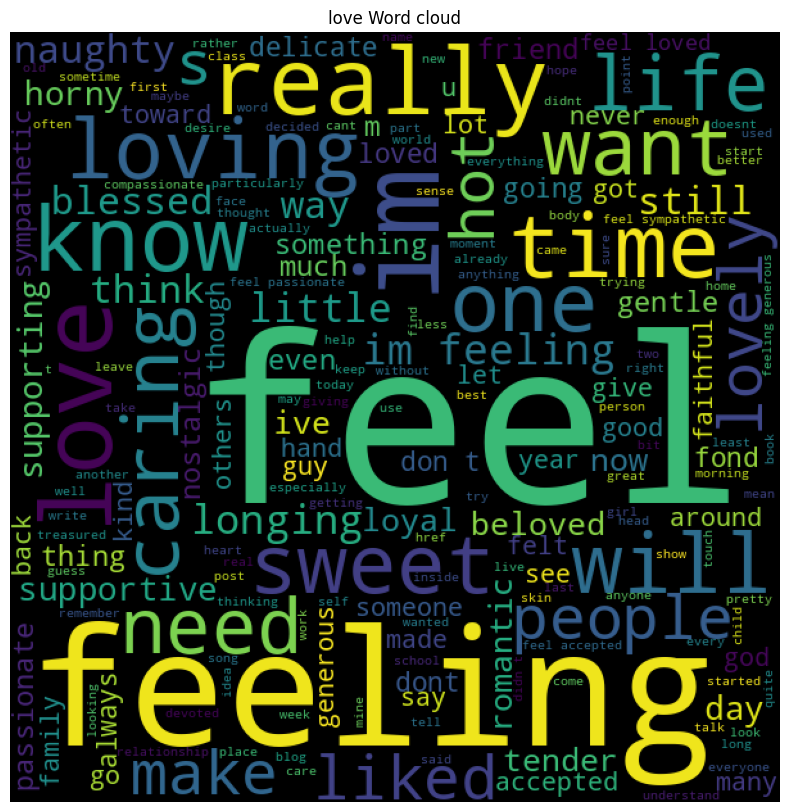

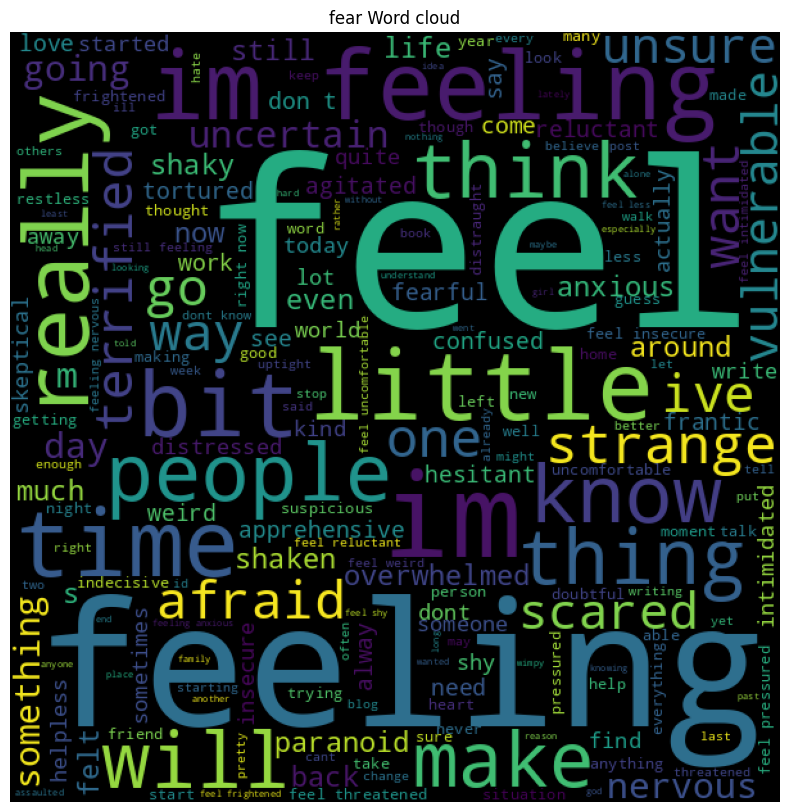

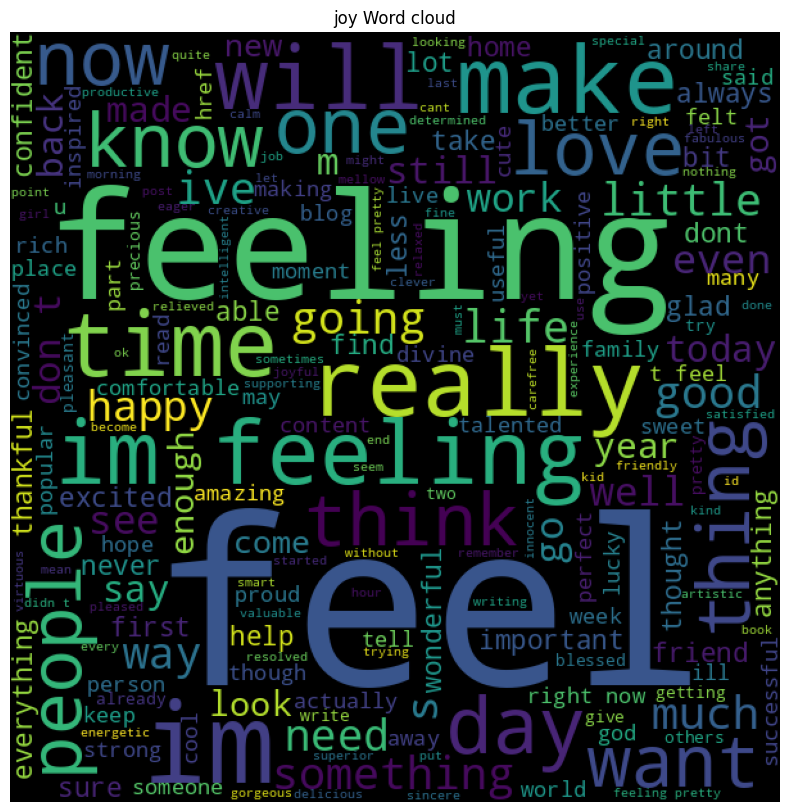

In [13]:
#word cloud 

#sadness word cloud 
def words_cloud(wordcloud, emotion):
    plt.figure(figsize=(10,10))
    plt.title(emotion + ' Word cloud')
    plt.imshow(wordcloud)
    plt.axis('off')

emotions_list = train_data['Emotion'].unique()

for emotion in emotions_list:
    text = " ".join([sentence for sentence  in train_data.loc[train_data['Emotion'] == emotion,'Sentences']])
    wordcloud = WordCloud(width=600 , height=600 ).generate(text)
    words_cloud(wordcloud , emotion)


DATA PREPROCESSING

In [14]:
lb = LabelEncoder()
train_data['Encoded_emotion'] = lb.fit_transform(train_data['Emotion'])
train_data

,Sentences,Emotion,length,Encoded_emotion
0,i didnt feel humiliated,sadness,23,4
1,i can go from feeling so hopeless to so damned...,sadness,108,4
2,im grabbing a minute to post i feel greedy wrong,anger,48,0
3,i am ever feeling nostalgic about the fireplac...,love,92,3
4,i am feeling grouchy,anger,20,0
...,...,...,...,...
15995,i just had a very brief time in the beanbag an...,sadness,101,4
15996,i am now turning and i feel pathetic that i am...,sadness,102,4
15997,i feel strong and good overall,joy,30,2
15998,i feel like this was such a rude comment and i...,anger,59,0


In [15]:
max((len(w) for w in train_data['Sentences']))

300

In [16]:
stopwords = set(nltk.corpus.stopwords.words('english'))

def clean_text(df , column  ,vocab_size ,max_len ):
    stemmer = PorterStemmer()  #converts words into its base form
    corpus = []
    for text in df[column]:
        text = re.sub("[^a-zA-z]",' ',text)
        text = text.lower()
        text = text.split()
        text = [stemmer.stem(w) for w in text if w not in stopwords]
        text = ' '.join(text)
        corpus.append(text)
    one_hot_word = [one_hot(input_text=word,n=vocab_size) for word in corpus ]
    pad = pad_sequences(sequences=one_hot_word,maxlen=max_len , padding='pre')
    return pad 
        

x_train = clean_text(train_data, 'Sentences', vocab_size=1100,max_len=300)


In [17]:
x_train

array([[   0,    0,    0, ...,  379,  512,  941],
       [   0,    0,    0, ...,  607,  308, 1056],
       [   0,    0,    0, ...,  512,   37,  748],
       ...,
       [   0,    0,    0, ...,  516,  416,   16],
       [   0,    0,    0, ...,  981,  211,  606],
       [   0,    0,    0, ...,  512,  610,  643]], dtype=int32)

In [18]:
x_train.shape

(15427, 300)

In [19]:
y_train = to_categorical(train_data['Encoded_emotion'])
y_train.shape

(15427, 5)

In [32]:
#LSTM Model 

model = Sequential()
model.add(Embedding(input_dim= 11000,output_dim=150,input_length=300))
model.add(Dropout(0.2))
model.add(LSTM(128))
model.add(Dropout(0.2))
model.add(Dense(64,activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(5,activation='softmax'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 300, 150)          1650000   
                                                                 
 dropout_3 (Dropout)         (None, 300, 150)          0         
                                                                 
 lstm_1 (LSTM)               (None, 128)               142848    
                                                                 
 dropout_4 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dropout_5 (Dropout)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 5)                

In [33]:
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])


In [34]:
#validation data
val_data = pd.read_csv("//kaggle/input/testtxt/val.txt",header=None , sep=';',names=['Sentences','Emotion'],encoding='utf-8')
val_data = train_data[train_data['Emotion'] != 'surprise']

val_data['Encoded_emotion'] = lb.transform(val_data['Emotion'])
x_val = clean_text(val_data, 'Sentences', vocab_size=1100, max_len=300)
y_val = to_categorical(val_data['Encoded_emotion'])

val_data


,Sentences,Emotion,length,Encoded_emotion
0,i didnt feel humiliated,sadness,23,4
1,i can go from feeling so hopeless to so damned...,sadness,108,4
2,im grabbing a minute to post i feel greedy wrong,anger,48,0
3,i am ever feeling nostalgic about the fireplac...,love,92,3
4,i am feeling grouchy,anger,20,0
...,...,...,...,...
15995,i just had a very brief time in the beanbag an...,sadness,101,4
15996,i am now turning and i feel pathetic that i am...,sadness,102,4
15997,i feel strong and good overall,joy,30,2
15998,i feel like this was such a rude comment and i...,anger,59,0


In [35]:
callback = keras.callbacks.EarlyStopping(monitor='loss',patience=3)
history = model.fit(x_train, y_train, epochs=100, batch_size=64, validation_data=(x_val, y_val),callbacks=[callback])


Epoch 1/100
242/242 [==============================] - 19s 68ms/step - loss: 1.3191 - accuracy: 0.4338 - val_loss: 0.8950 - val_accuracy: 0.6651
Epoch 2/100
242/242 [==============================] - 10s 39ms/step - loss: 0.7393 - accuracy: 0.7143 - val_loss: 0.5285 - val_accuracy: 0.7946
Epoch 3/100
242/242 [==============================] - 8s 33ms/step - loss: 0.5634 - accuracy: 0.7719 - val_loss: 0.4395 - val_accuracy: 0.8173
Epoch 4/100
242/242 [==============================] - 8s 32ms/step - loss: 0.5047 - accuracy: 0.7886 - val_loss: 0.4051 - val_accuracy: 0.8291
Epoch 5/100
242/242 [==============================] - 7s 31ms/step - loss: 0.4658 - accuracy: 0.8008 - val_loss: 0.3894 - val_accuracy: 0.8322
Epoch 6/100
242/242 [==============================] - 8s 32ms/step - loss: 0.4359 - accuracy: 0.8132 - val_loss: 0.3608 - val_accuracy: 0.8409
Epoch 7/100
242/242 [==============================] - 8s 31ms/step - loss: 0.4130 - accuracy: 0.8203 - val_loss: 0.3373 - val_accurac

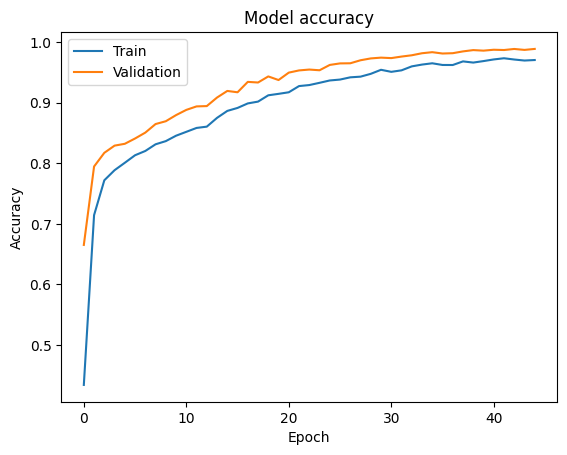

In [36]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


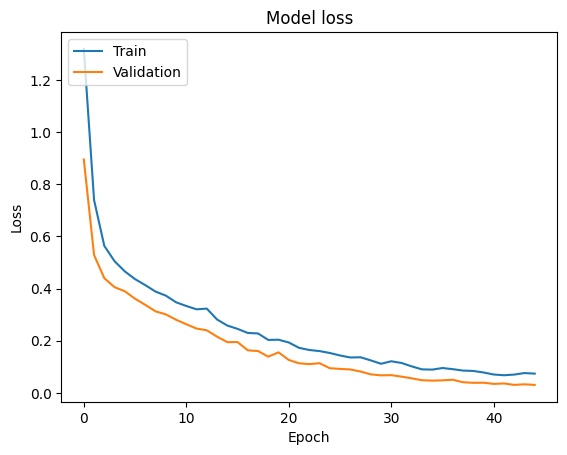

In [37]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


In [38]:
# Load test data
test_data = pd.read_csv("//kaggle/input/testtxt/test.txt",header=None , sep=';',names=['Sentences','Emotion'],encoding='utf-8')
test_data = test_data[test_data['Emotion'] != 'surprise']

test_data['Encoded_emotion'] = lb.transform(test_data['Emotion'])
x_test = clean_text(test_data, 'Sentences', vocab_size=1100, max_len=300)
y_test = to_categorical(test_data['Encoded_emotion'])


# Make predictions
predictions = model.predict(x_test)

# Convert predictions to emotion labels
predicted_emotions = lb.inverse_transform(predictions.argmax(axis=1))

# Convert actual labels to emotion names
actual_emotions = lb.inverse_transform(test_data['Encoded_emotion'])

# Display actual labels and predictions
print(f"{'':<10}{'Actual Emotion':<20}{'Predicted Emotion':<20}{'Sentence'}")
print("="*70)
for actual, predicted, sentence in zip(actual_emotions, predicted_emotions, test_data['Sentences']):
    print(f"{'':<10}{actual:<20}{predicted:<20}{sentence}")

61/61 [==============================] - 1s 8ms/step
          Actual Emotion      Predicted Emotion   Sentence
          sadness             sadness             im feeling rather rotten so im not very ambitious right now
          sadness             sadness             im updating my blog because i feel shitty
          sadness             sadness             i never make her separate from me because i don t ever want her to feel like i m ashamed with her
          joy                 joy                 i left with my bouquet of red and yellow tulips under my arm feeling slightly more optimistic than when i arrived
          sadness             sadness             i was feeling a little vain when i did this one
          fear                fear                i cant walk into a shop anywhere where i do not feel uncomfortable
          anger               anger               i felt anger when at the end of a telephone call
          joy                 joy                 i explain 

In [39]:
test_loss, test_accuracy = model.evaluate(x_test, y_test)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy*100:.2f}%")

61/61 [==============================] - 1s 10ms/step - loss: 1.7436 - accuracy: 0.7404
Test Loss: 1.7436
Test Accuracy: 74.04%


In [40]:
model.save('LSTMModel_f1_75.h5')

# Save the LabelEncoder
with open('lb1.pkl', 'wb') as f:
    pickle.dump(lb, f)

# Save vocabulary size and max length
vocab_info = {'vocab_size': 11000, 'max_len': 300}
with open('vocab_info.pkl', 'wb') as f:
    pickle.dump(vocab_info, f)

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
